In [59]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm
import ast  # for litteral_eval

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
# from sklearn.utils import resample
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
# from sklearn.ensemble import BaggingRegressor
# from sklearn.neural_network import MLPRegressor, MLPClassifier
# from xgboost import XGBClassifier, XGBRegressor

from utils import settings
from utils.utils import get_file_names, open_files, save_files
from utils.visualization import units, visualize_features
from utils.feature_analysis import test_stationarity, remove_non_stationary_features, seasonal_decomposition, remove_seasonality, vif_analysis, shift_features
from utils.model_processing import *
import warnings
warnings.filterwarnings('ignore')

In [60]:
# sns.set()

# initialize the list of all settings to be used in this file
settings.init()

SEED = 450

## Data preparation

In [61]:
data = pd.read_csv("Data/dataset_monthly.csv", sep=';')
data_pct_change = pd.read_csv("Data/dataset_monthly_pct_change.csv", sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data_pct_change['Date'] = pd.to_datetime(data_pct_change['Date'])

settings.add('ORIGINAL_COLS', data.columns)  # names of raw features
settings.add('UNITS', units)  # units are in utils.visualization

data = pd.merge(data, data_pct_change, on='Date')

In [62]:
# handle political orientation categories: D = 1, R = 0
pol_columns = ['potus', 'houseOfRep', 'fedChair']
for col in pol_columns:
    data[col] = data[col] == 'D'

# create X and Y sets
Y_COL = ['Fed_rate_month_avg', 'Fed_rate_spot_EOM',
         'Fed_rate_month_avg_diff', 'Fed_rate_month_avg_pct_change',
         'Fed_rate_month_avg_diff_3_class', 'Fed_rate_month_avg_diff_5_class',
         'Fed_rate_month_avg_diff_9_class', 'Fed_rate_month_avg_trend'
        ]
X_non_cols = ['Fed_rate_month_avg', 'Fed_rate_spot_EOM',
         'Fed_rate_month_avg_diff_3_class', 'Fed_rate_month_avg_diff_5_class',
         'Fed_rate_month_avg_diff_9_class', 'Fed_rate_month_avg_trend'
        ]
X, Y = data.drop(columns=X_non_cols), data[Y_COL + ['Date']]

In [63]:
# Create two settings for non numeric features and numeric features
settings.add('NON_NUM_COLS', ['Date', 'Recession', 'potus', 'houseOfRep', 'fedChair'])  # non numeric features (boolean, date, etc)
settings.add('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])  # numeric features

# Exclude features without seasonality correction already implemented
settings.add('EXCL_COLS', [c for c in X.columns if c.lower().replace('_pct_change', '')[-5:] == 'unadj'])

# Remaining features for next steps in X (useful only for experiments)
settings.add('KEPT_COLS', list(X.columns))
# settings.remove_columns_names('KEPT_COLS', ['Date'])
settings.remove_columns_names('KEPT_COLS',settings.get('EXCL_COLS'))

X = X[settings.get('KEPT_COLS')]
X.describe()

cpi_all_seas  cpi_energy_seas  cpi_less_energy_seas  \
count    868.000000       760.000000            760.000000   
mean     111.999953       105.167158            127.090921   
std       78.020747        72.562924             77.183956   
min       23.500000        21.300000             28.400000   
25%       32.030000        27.775000             43.875000   
50%      102.750000       100.600000            123.350000   
75%      178.700000       151.200000            194.475000   
max      259.050000       271.149000            265.539000   

       empl_pop_ratio_seas  unempl_level_seas  unempl_rate_seas  \
count           868.000000         868.000000        868.000000   
mean             59.259562        6512.306452          5.737558   
std               2.744295        3018.715065          1.673670   
min              51.300000        1596.000000          2.500000   
25%              57.000000        3955.250000          4.500000   
50%              58.700000        6598.500000          5.500000   
75%              61.900000        8185.500000          6.800000   
max              64.700000       23078.000000         14.700000   

       EA19_GDP_gth_rate  EU27_2020_GDP_gth_rate  G-20_GDP_gth_rate  \
count         299.000000              299.000000         263.000000   
mean            0.001183                0.001334           0.002928   
std             0.002201                0.002113           0.001510   
min            -0.012662               -0.011226          -0.004994   
25%             0.000646                0.000867           0.002458   
50%             0.001508                0.001687           0.002930   
75%             0.002192                0.002340           0.003784   
max             0.004271                0.004199           0.004875   

       G-7_GDP_gth_rate  ...  US_debt_share_in_GDP_pct_change  \
count        695.000000  ...                       652.000000   
mean           0.002295  ...                         0.001555   
std            0.002114  ...                         0.005829   
min           -0.007653  ...                        -0.014084   
25%            0.001287  ...                        -0.001868   
50%            0.002083  ...                         0.001702   
75%            0.003506  ...                         0.004684   
max            0.008321  ...                         0.029183   

       US_debt_nominal_pct_change  USDCNY_pct_change  EURUSD_pct_change  \
count                  652.000000         340.000000         244.000000   
mean                     0.006674           0.001086           0.000958   
std                      0.004922           0.028054           0.028302   
min                     -0.008246          -0.033474          -0.097206   
25%                      0.003354          -0.002281          -0.014062   
50%                      0.006968          -0.000073           0.000262   
75%                      0.009721           0.000145           0.018226   
max                      0.022460           0.500000           0.101047   

       VIX_pct_change  GSPC(S&P500)_pct_change  trade_balance_All_pct_change  \
count      364.000000               868.000000                    339.000000   
mean         0.023315                 0.006931                      0.020354   
std          0.224975                 0.041919                      0.174109   
min         -0.396151                -0.217817                     -0.589832   
25%         -0.117434                -0.017200                     -0.046366   
50%         -0.006785                 0.009546                      0.012985   
75%          0.102202                 0.034208                      0.069123   
max          1.483268                 0.163047                      2.178099   

       trade_balance_Goods_pct_change  trade_balance_Services_pct_change  \
count                      339.000000                         339.000000   
mean                         0.009265                           0.006

## Data visualization

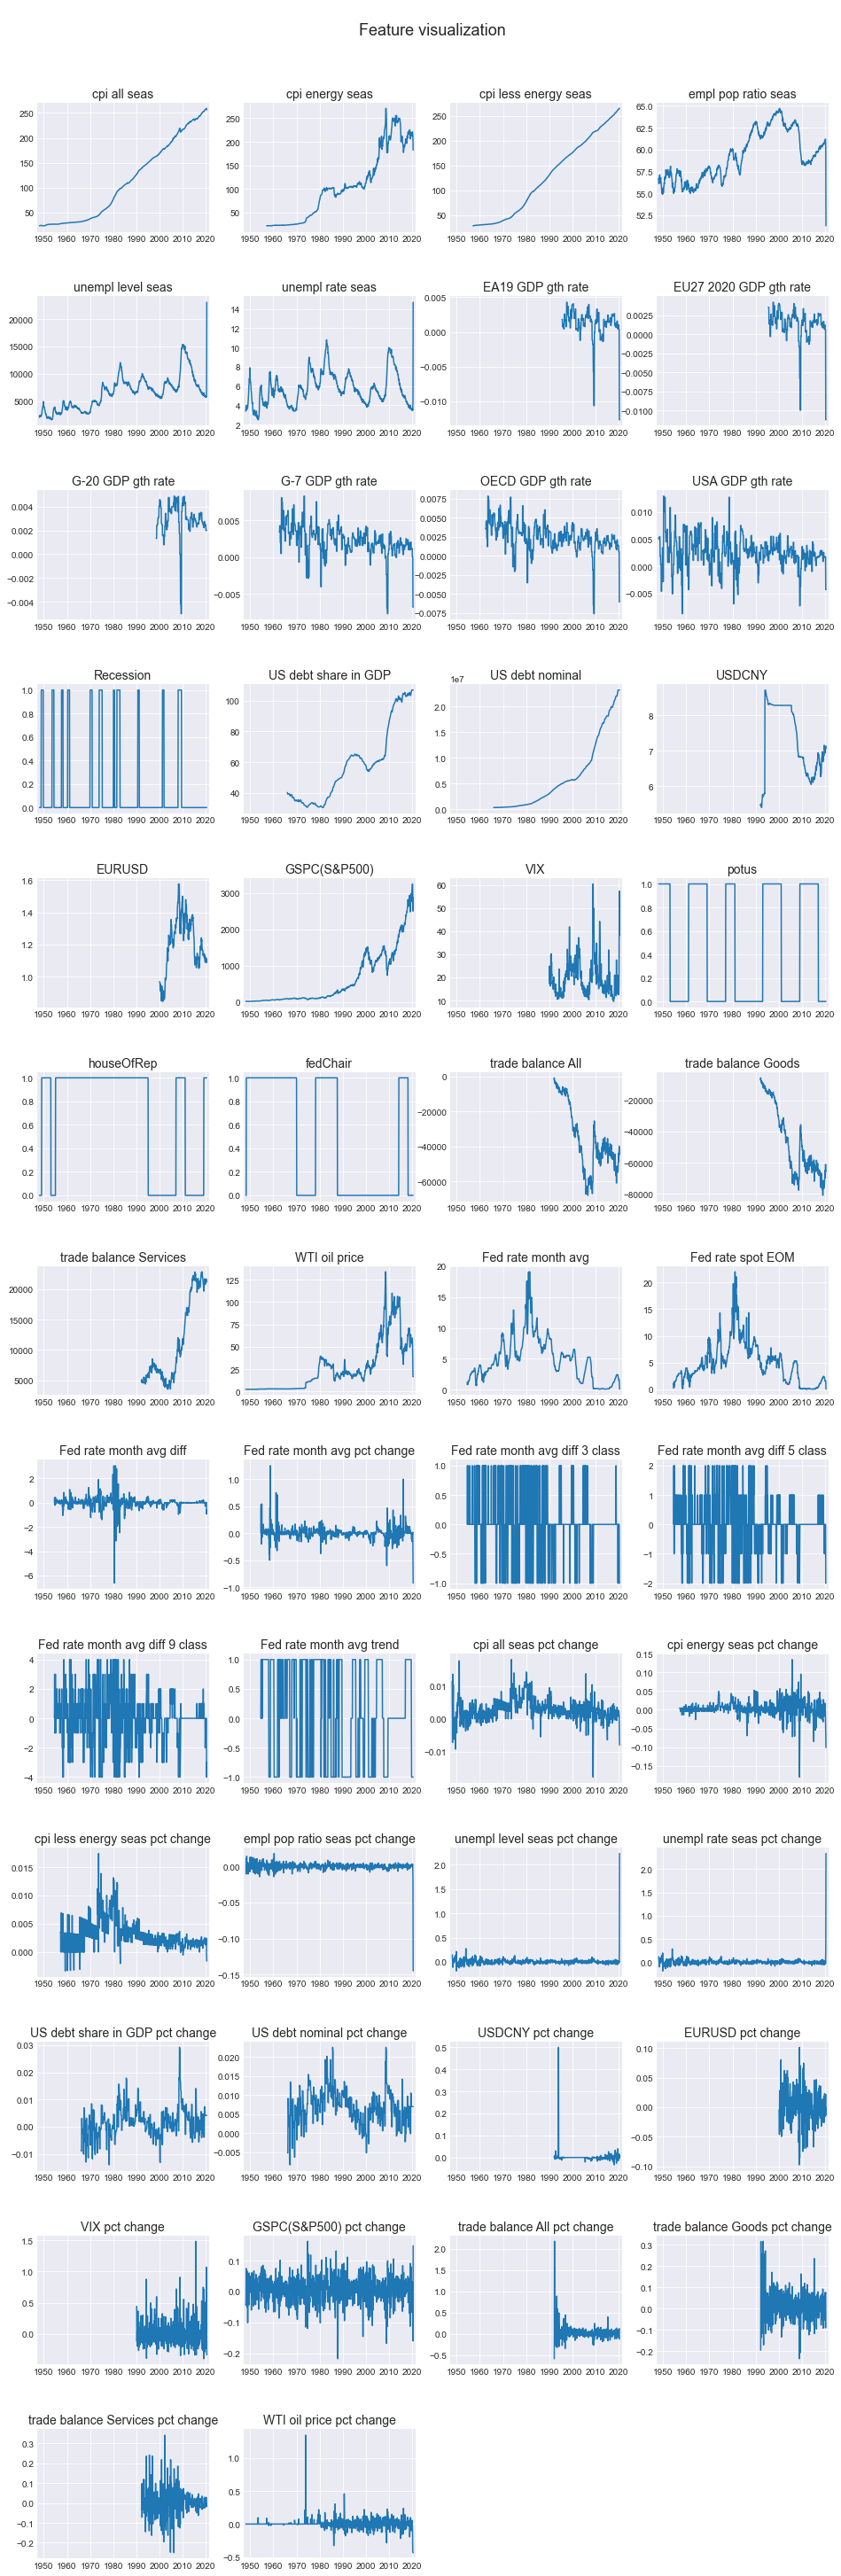

In [64]:
visualize_features(data=data,
                   excl_cols = settings.get('EXCL_COLS'),
                   date_col='Date',
                   ncols=4,
                   height_per_ax=3
                  )

## Feature selection

### 1. Feature stationarity

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

#### Dickey-Fuller test to ensure stationarity of variables

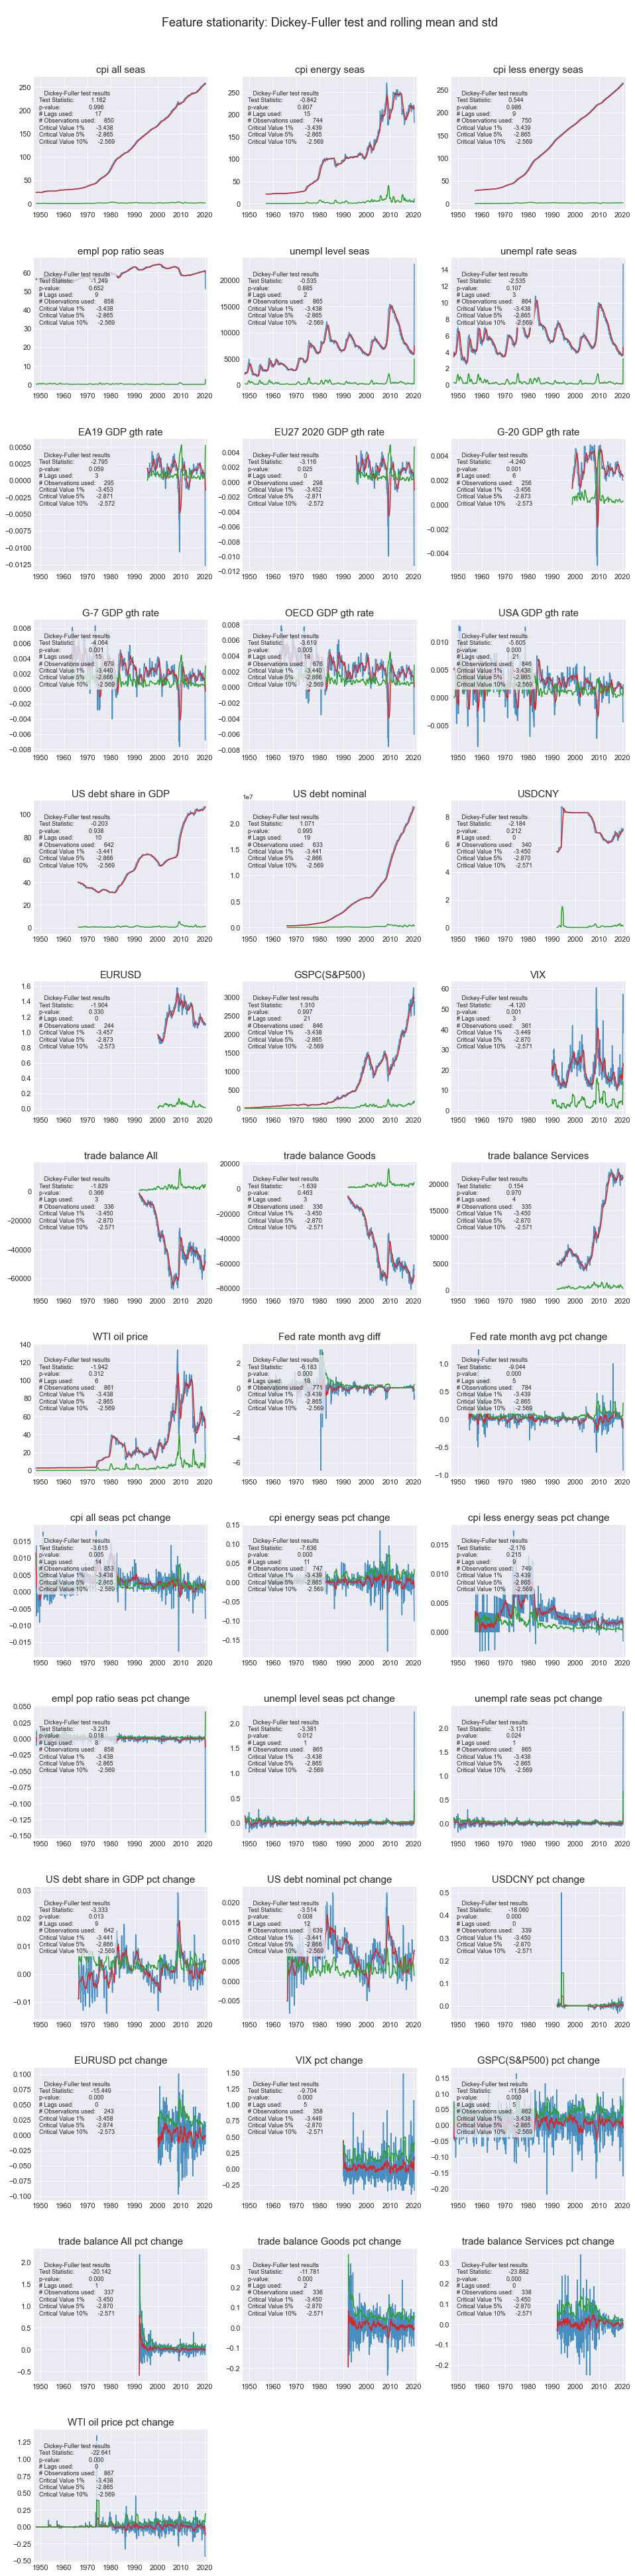

In [65]:
stat_results = test_stationarity(data,
                                columns=settings.get('NUM_COLS'),
                                excl_cols=settings.get('EXCL_COLS'),
                                date_col='Date',
                                stat_conf_level='5%',
                                plot_graphs=True,
                                plot_test_results=True
                               )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [66]:
kept_cols, dropped_cols = remove_non_stationary_features(X, stat_results)
settings.update('EXCL_COLS', settings.get('EXCL_COLS') + dropped_cols)
settings.update('KEPT_COLS',kept_cols)
X.describe()


------------------------------------- Non-stationarity: following features dropped -------------------------------------
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
unempl_rate_seas
EA19_GDP_gth_rate
US_debt_share_in_GDP
US_debt_nominal
USDCNY
EURUSD
GSPC(S&P500)
VIX_pct_change
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI_oil_price


cpi_all_seas_pct_change  cpi_energy_seas_pct_change  \
count               868.000000                  759.000000   
mean                  0.002765                    0.003052   
std                   0.003338                    0.020865   
min                  -0.017705                   -0.180245   
25%                   0.000992                   -0.004175   
50%                   0.002417                    0.003158   
75%                   0.004253                    0.009678   
max                   0.018100                    0.134605   

       cpi_less_energy_seas_pct_change  empl_pop_ratio_seas_pct_change  \
count                       759.000000                      867.000000   
mean                          0.002950                       -0.000093   
std                           0.002514                        0.006103   
min                          -0.003356                       -0.145000   
25%                           0.001494                       -0.001706   
50%                           0.002440                        0.000000   
75%                           0.003647                        0.001721   
max                           0.017429                        0.018051   

       unempl_level_seas_pct_change  unempl_rate_seas_pct_change  \
count                    867.000000                   867.000000   
mean                       0.004765                     0.003751   
std                        0.085177                     0.088649   
min                       -0.187144                    -0.189873   
25%                       -0.019261                    -0.021277   
50%                       -0.000404                     0.000000   
75%                        0.019357                     0.020204   
max                        2.232213                     2.340909   

       EU27_2020_GDP_gth_rate  G-20_GDP_gth_rate  G-7_GDP_gth_rate  \
count              299.000000         263.000000        695.000000   
mean                 0.001334           0.002928          0.002295   
std                  0.002113           0.001510          0.002114   
min                 -0.011226          -0.004994         -0.007653   
25%                  0.000867           0.002458          0.001287   
50%                  0.001687           0.002930          0.002083   
75%                  0.002340           0.003784          0.003506   
max                  0.004199           0.004875          0.008321   

       OECD_GDP_gth_rate  ...  USDCNY_pct_change  EURUSD_pct_change  \
count         695.000000  ...         340.000000         244.000000   
mean            0.002456  ...           0.001086           0.000958   
std             0.001954  ...           0.028054           0.028302   
min            -0.007575  ...          -0.033474          -0.097206   
25%             0.001477  ...          -0.002281          -0.014062   
50%             0.002392  ...          -0.000073           0.000262   
75%             0.003564  ...           0.000145           0.018226   
max             0.007837  ...           0.500000           0.101047   

       GSPC(S&P500)_pct_change         VIX  trade_balance_All_pct_change  \
count               868.000000  365.000000                    339.000000   
mean                  0.006931   19.586438                      0.020354   
std                   0.041919    7.974378                      0.174109   
min                  -0.217817    9.590000                     -0.589832   
25%                  -0.017200   13.750000                     -0.046366   
50%                   0.009546   17.420000                      0.012985   
75%                   0.034208   22.900000                      0.069123   
max                   0.163047   60.470001                      2.178099   

       trade_balance_Goods_pct_change  trade_balance_Services_pct_change  \
count                      339.000000                         339.000000   
mean                         0.009265                       

### 2. Feature seasonality

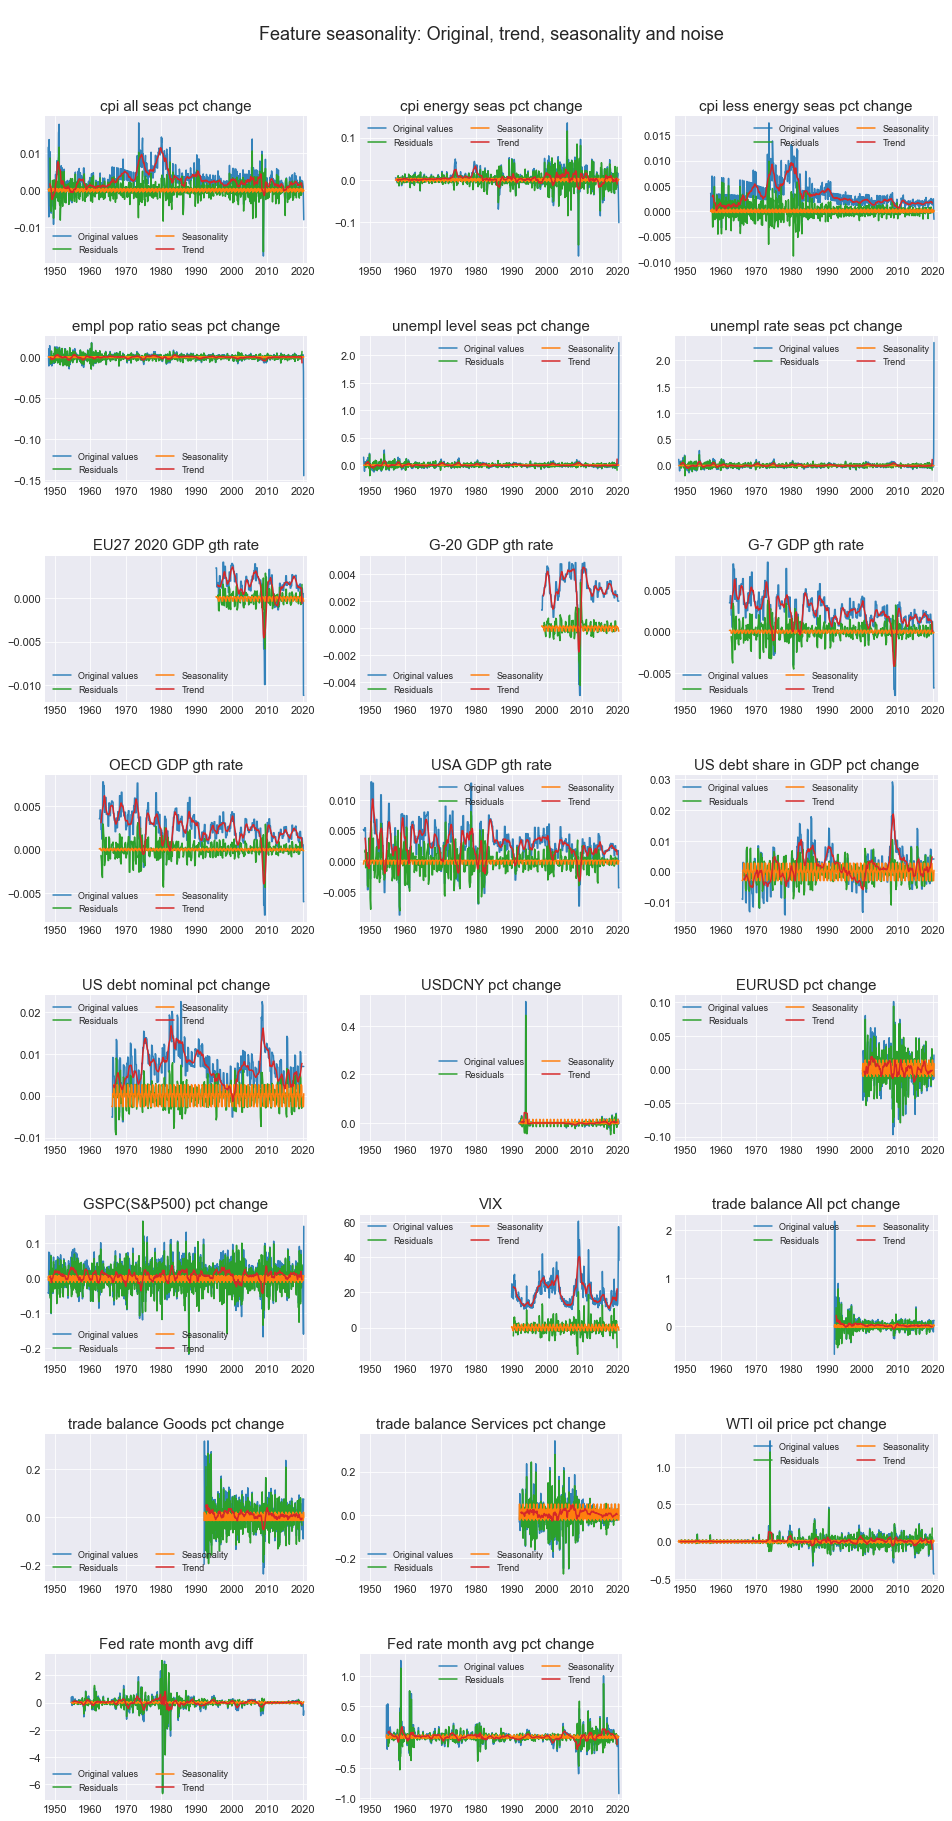

In [67]:
X_trend, X_seas, X_resid = seasonal_decomposition(X,
                                                 date_col='Date',
                                                 excl_cols=settings.get('NON_NUM_COLS'),
                                                 plot_graphs=True,
                                                 height_per_ax=3,
                                                 ncols=3
                                                )

In [68]:
_ = remove_seasonality(X, X_seas, threshold = 0.15)        

----------------------------------- Seasonality removed from the following features ------------------------------------
cpi_energy_seas_pct_change
cpi_less_energy_seas_pct_change
US_debt_share_in_GDP_pct_change
US_debt_nominal_pct_change
USDCNY_pct_change
EURUSD_pct_change
GSPC(S&P500)_pct_change
VIX
trade_balance_Goods_pct_change
trade_balance_Services_pct_change
WTI_oil_price_pct_change
Fed_rate_month_avg_pct_change
------------------------------ Following features not found in provided data or data_seas ------------------------------
Recession
potus
houseOfRep
fedChair


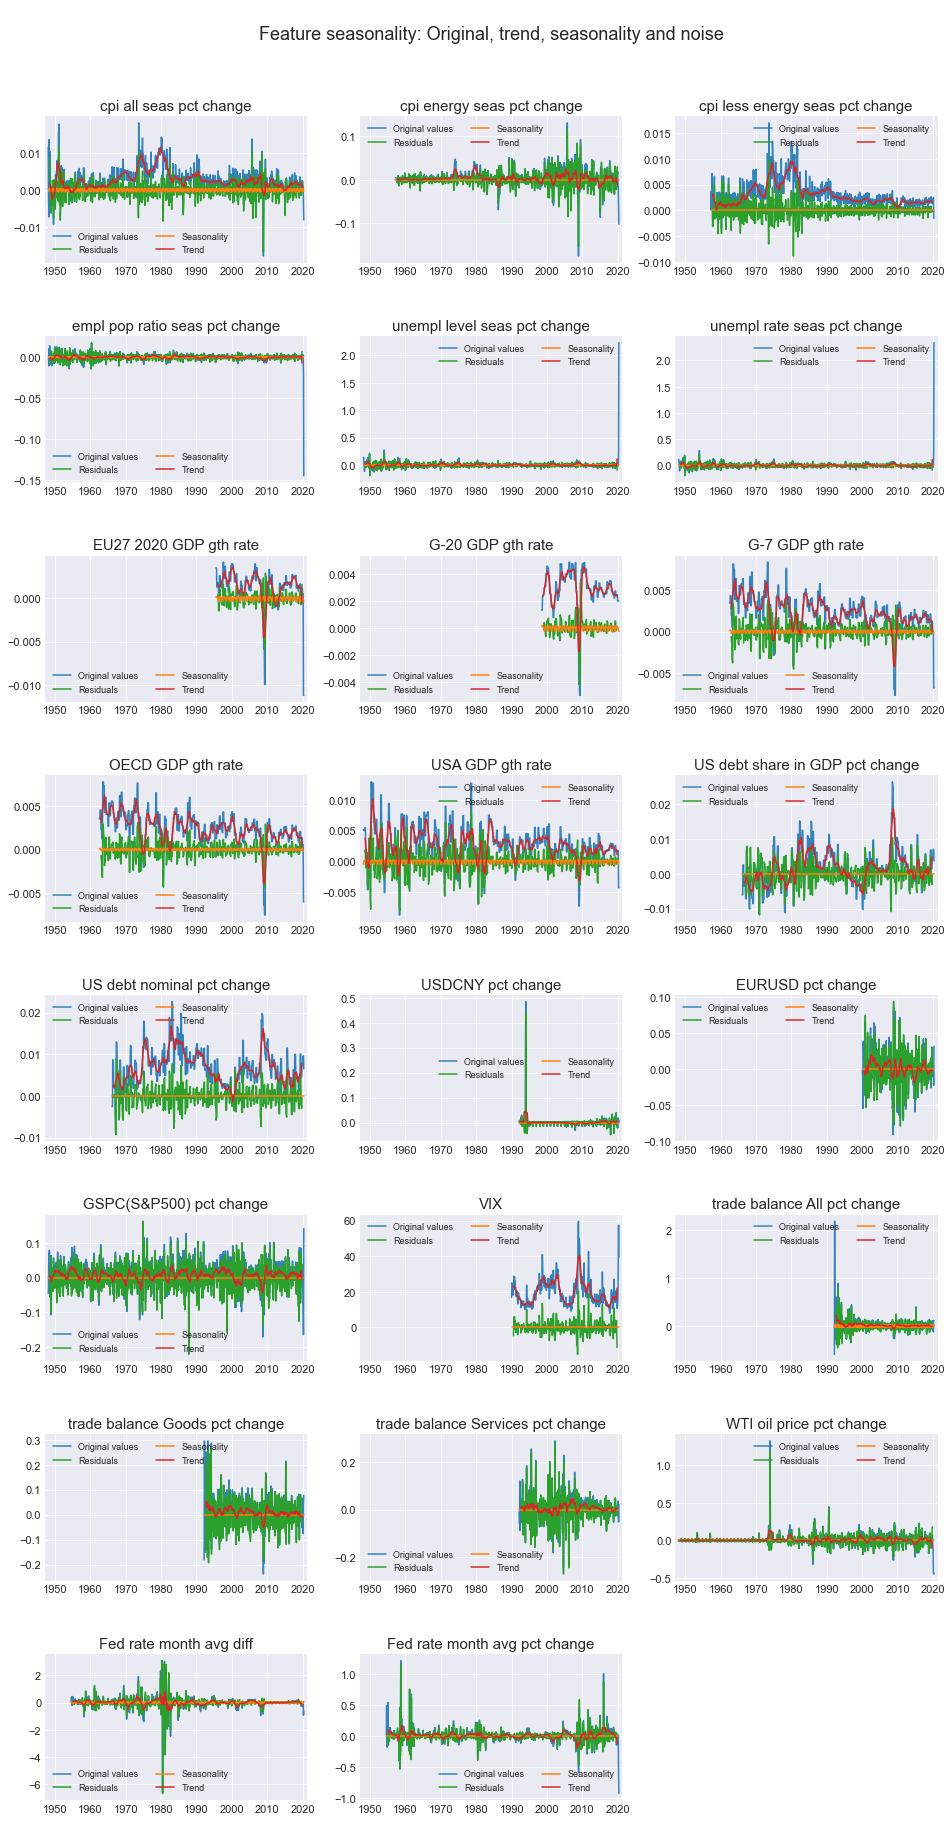

In [69]:
_, _, _ = seasonal_decomposition(X,
                                 date_col='Date',
                                 excl_cols=settings.get('NON_NUM_COLS'),
                                 plot_graphs=True,
                                 height_per_ax=3,
                                 ncols=3
                                )

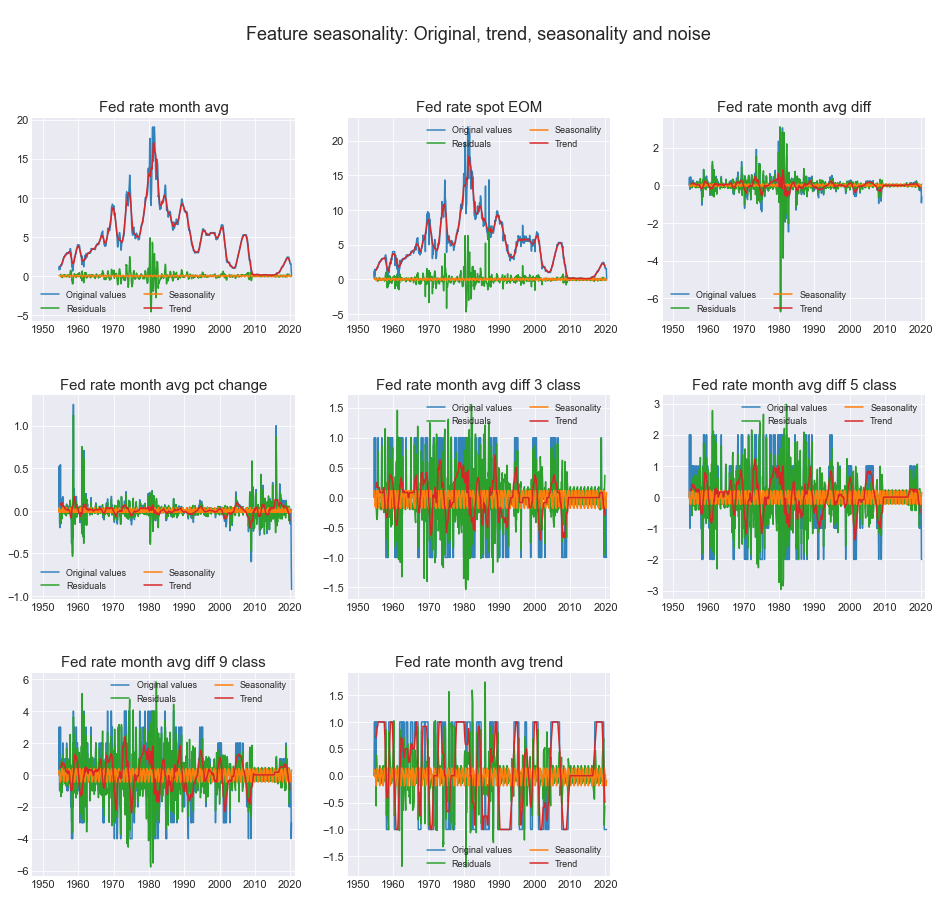

In [70]:
Y_trend, Y_seas, Y_resid = seasonal_decomposition(Y,
                                                 date_col='Date',
                                                 plot_graphs=True,
                                                 height_per_ax=4,
                                                 width_per_ax=6,                                                
                                                 ncols=3
                                                )

### 3. Feature normalization

In [71]:
scaled_cols = [x for x in settings.get('KEPT_COLS') if x in settings.get('NUM_COLS')]
X_scaled = preprocessing.StandardScaler().fit_transform(X[scaled_cols])
X[scaled_cols] = pd.DataFrame(X_scaled, columns=scaled_cols)

### 4. Add lagged features

In [72]:
settings.add('ROW_SHIFT', (1, 2, 3, 6, 12))
data_shifted = shift_features(X,
                              row_shifts = (1, 2, 3, 6, 12,)
#                               row_shifts=settings.get('ROW_SHIFT')
                             )
X = pd.concat([X, data_shifted], axis=1)  

In [73]:
# X[['EURUSD_pct_change', 'Date']].dropna()

In [74]:
X.drop(columns=list(set(x.split("_t-")[0] for x in X.columns) - set(['Date'])), inplace=True)

In [75]:
# Boolean features were converted to weird type, let's convert them back to booleans
X.loc[:, X.dtypes == 'O'] = X.loc[:, X.dtypes == 'O'].astype(bool)

### 5. Feature correlation

In [76]:
# set important dates for X and Y
settings.add('START_DATE', dt.datetime(1960, 1, 1))
# settings.add('START_DATE', dt.datetime(1992, 1, 1))
# settings.add('START_DATE', dt.datetime(2001, 2, 1))
settings.add('END_DATE', dt.datetime(2020, 5, 1))

#### Dropping features with NAN within start date and end date

In [77]:
# Only after START DATE
try:
    X = X.loc[(X['Date'] >= settings.get('START_DATE')) & (X['Date'] <= settings.get('END_DATE'))]
    Y = Y.iloc[X.index]
except IndexError:
    pass

# Removing features with NaN after STARTDATE
X = X.dropna(axis=1)

# Ensuring Y has values everywhere
# Y = Y.dropna()
# X = X.iloc[Y.index]

#### First correlation matrix

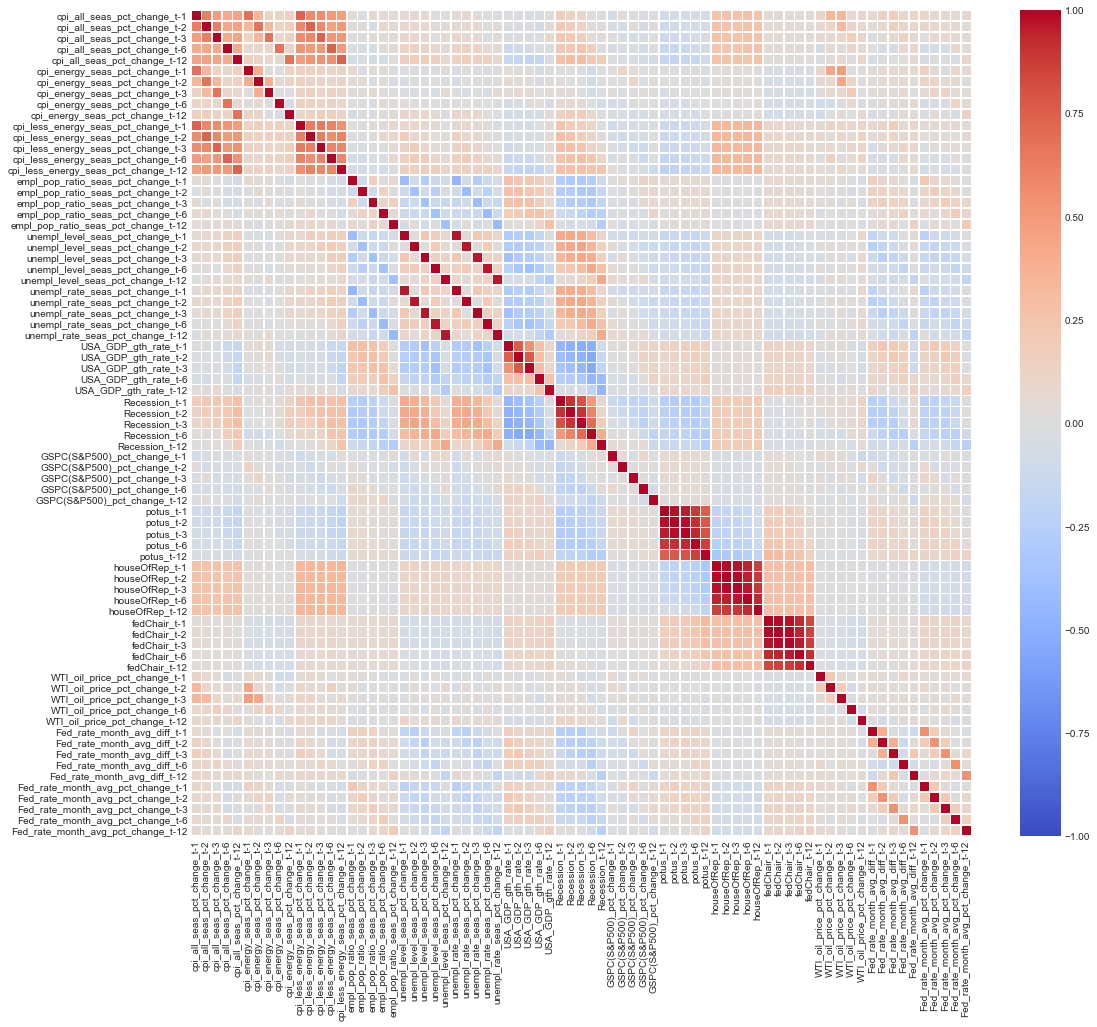

In [78]:
fig = plt.figure(figsize = (0.23 * len(X.columns), 0.2 * len(X.columns)))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

#### VIF analysis

In [79]:
# Compute features to be analysed by VIF
columns_vif = [x for x in X.columns if x.split("_t-")[0] in settings.get('NUM_COLS')]

In [87]:
vif, excl_columns_vif = vif_analysis(X, columns_vif, threshold=10)
vif.sort_values('VIF_factor', ascending=False).head()


KeyError: "['unempl_rate_seas_pct_change_t-6', 'cpi_all_seas_pct_change_t-6', 'cpi_all_seas_pct_change_t-3', 'unempl_rate_seas_pct_change_t-1', 'unempl_rate_seas_pct_change_t-12', 'cpi_all_seas_pct_change_t-2', 'unempl_rate_seas_pct_change_t-3', 'unempl_rate_seas_pct_change_t-2', 'cpi_all_seas_pct_change_t-12', 'cpi_all_seas_pct_change_t-1'] not in index"

In [81]:
pd.DataFrame.from_dict(excl_columns_vif, orient='index', columns=['VIF value when excluded'])

VIF value when excluded
unempl_rate_seas_pct_change_t-2                 32.162073
unempl_rate_seas_pct_change_t-1                 18.437155
unempl_rate_seas_pct_change_t-12                17.725522
unempl_rate_seas_pct_change_t-3                 16.878962
unempl_rate_seas_pct_change_t-6                 16.687462
cpi_all_seas_pct_change_t-2                     12.628302
cpi_all_seas_pct_change_t-3                     11.375914
cpi_all_seas_pct_change_t-1                     11.175364
cpi_all_seas_pct_change_t-6                     10.610865
cpi_all_seas_pct_change_t-12                    10.100458

In [82]:
for col_name in excl_columns_vif.keys():
    try:
        X.drop(columns=[col_name], inplace=True)
    except KeyError:
        print("Column {:s} have already been removed".format(col_name))

#### FInal correlation matrix

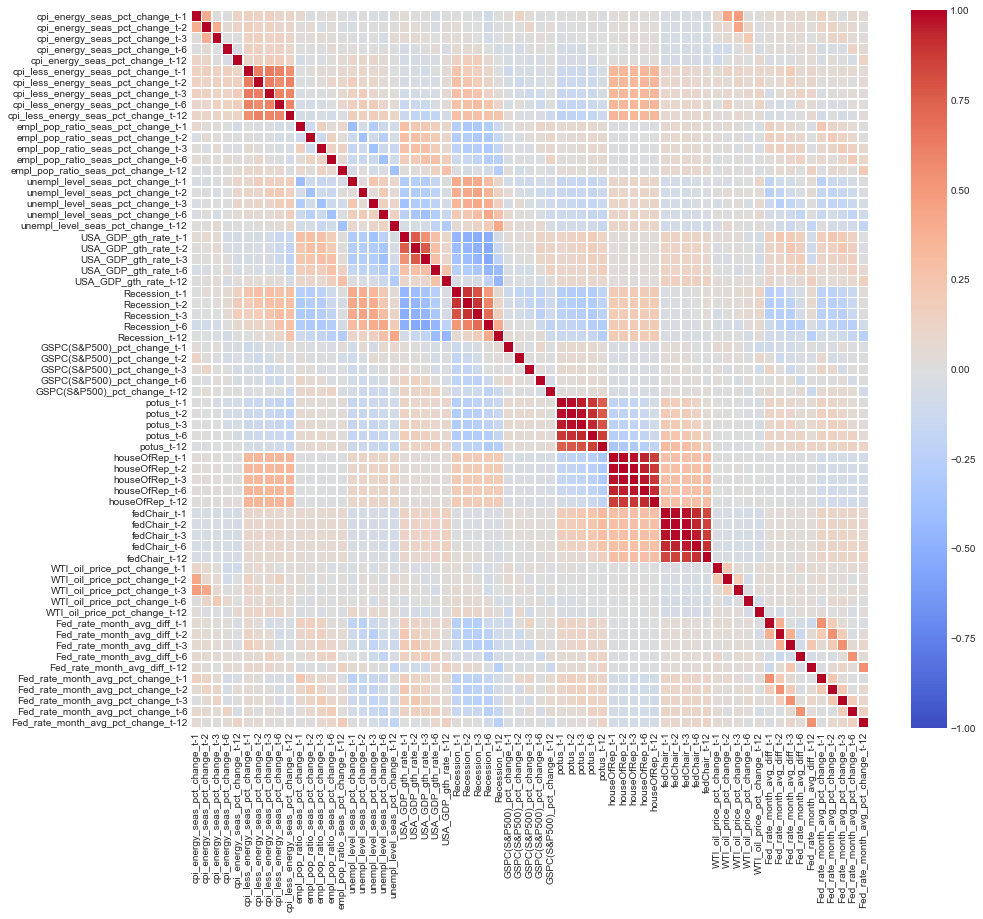

In [83]:
fig = plt.figure(figsize = (0.23 * len(X.columns), 0.2 * len(X.columns)))
heat_map = sns.heatmap(X.dropna().corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

### 6. Train and Test split and save dataset

In [84]:
train_test_ratio = 0.7
test_date = settings.get('START_DATE') + train_test_ratio * (settings.get('END_DATE') - settings.get('START_DATE'))
settings.add('TEST_DATE', test_date)

X_train, X_test = X.loc[X['Date'] < settings.get('TEST_DATE')], X.loc[X['Date'] >= settings.get('TEST_DATE')]
Y_train, Y_test = Y.loc[Y['Date'] < settings.get('TEST_DATE')], Y.loc[Y['Date'] >= settings.get('TEST_DATE')]
X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

In [85]:
files = [X_train, Y_train, X_test, Y_test]
file_names = ["X_train", "Y_train", "X_test", "Y_test"]
file_names = [f + "_t-" + "_".join([str(i) for i in settings.get('ROW_SHIFT')]) + ".csv" for f in file_names]
save_files(
    path='Models/startdate_{:s}_testdate_{:s}/'.format(settings.get('START_DATE').strftime("%Y"),
                                                       settings.get('TEST_DATE').strftime("%Y")
                                                      ),
    files=dict(zip(file_names, files)),
    replace=True
    )


------------------------- 4 file(s) saved succesfully in Models/startdate_1960_testdate_2002/ --------------------------


In [86]:
path = 'Models/startdate_{:s}_testdate_{:s}/'.format(settings.get('START_DATE').strftime("%Y"),
                                                       settings.get('TEST_DATE').strftime("%Y")
                                                      )
test = pd.read_csv(path + 'X_train_t-1_2_3_6_12.csv', sep=';')
with pd.option_context('max_columns', 200):
    print(test.head(20))

    cpi_energy_seas_pct_change_t-1  cpi_energy_seas_pct_change_t-2  \
0                         0.204210                        0.069511   
1                        -0.212923                        0.204210   
2                        -0.338896                       -0.212923   
3                         0.082497                       -0.338896   
4                         0.024323                        0.082497   
5                        -0.362800                        0.024323   
6                        -0.085242                       -0.362800   
7                         0.102556                       -0.085242   
8                        -0.251005                        0.102556   
9                        -0.099785                       -0.251005   
10                       -0.246939                       -0.099785   
11                        0.498199                       -0.246939   
12                       -0.225486                        0.498199   
13                  